<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../')) 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial
from scipy.stats import bootstrap
from scipy.stats import lognorm


pd.set_option('display.max_rows', 500)

In [4]:
# load population data

total_pop = pd.read_csv("../state/CA/CA_total_pop_by_crime_category.csv")
total_pop = total_pop.iloc[:, :6]

# load admissions data

admissions = pd.read_csv("../state/CA/CA_admissions_by_crime_category.csv")
admissions = admissions.iloc[:, :6]

In [5]:
admissions

,Date,Crimes Against Persons,Property Crimes,Drug Crimes,Other Crimes,Missing
0,January 2018,"1,372",563,256,635,NaN
1,February 2018,"1,405",509,208,582,NaN
2,March 2018,"1,711",621,283,746,NaN
3,April 2018,"1,334",535,222,580,NaN
4,May 2018,"1,832",607,278,745,NaN
5,June 2018,"1,574",611,212,687,NaN
6,July 2018,"1,722",630,257,707,NaN
7,August 2018,"1,593",561,234,717,NaN
8,September 2018,"1,312",517,224,618,NaN
9,October 2018,"1,650",605,230,668,NaN


Preprocess the data: make sure that the data types are right, the numbers are formatted properly, deal with missing values, etc.

In [6]:
# create month and year columns for total_pop

month_year = total_pop.Date.str.split(" " , n=1, expand = True)
total_pop["Month"], total_pop["Year"] = month_year.iloc[:, 0], month_year.iloc[:, 1]
total_pop = total_pop.drop("Date", axis = 1)

total_pop.Month = total_pop.index % 12 + 1

# another way to do this:
# month_to_number = {"January": 1, "February": 2, ...}
# total_pop.Month = total_pop.Month.map(month_to_number)

# a third way to do this:
# for i in range (len(total_pop)): 
#    total_pop.iloc[i,5] = i % 12 + 1

# create month and year columns for admissions table

month_year_admissions = admissions.Date.str.split(" " , n=1, expand = True)
admissions["Month"], admissions["Year"] = month_year_admissions.iloc[:, 0], month_year_admissions.iloc[:, 1]
admissions = admissions.drop("Date", axis = 1)

admissions.Month = admissions.index % 12 + 1

In [7]:
# remove commas from columns

def remove_commas(df, column_name):
    df[f"{column_name}"] = df[f"{column_name}"].apply(lambda x: x.replace(",", ""))

remove_commas(total_pop, "Crimes Against Persons")
remove_commas(total_pop, "Property Crimes")
remove_commas(total_pop, "Drug Crimes")
remove_commas(total_pop, "Other Crimes")

remove_commas(admissions, "Crimes Against Persons")
remove_commas(admissions, "Property Crimes")
remove_commas(admissions, "Drug Crimes")
remove_commas(admissions, "Other Crimes")

In [8]:
# check data types of columns in each df

total_pop.dtypes
admissions.dtypes

Crimes Against Persons    object
Property Crimes           object
Drug Crimes               object
Other Crimes              object
Missing                   object
Month                      int64
Year                      object
dtype: object

In [9]:
# change types of total_pop columns, drop Missing column

total_pop = total_pop.drop("Missing", axis=1)
total_pop = total_pop.astype(int)

# replace x's and *'s in code, drop Missing column

admissions = admissions.drop("Missing", axis=1)


In [10]:
admissions = admissions.replace("*", 5)
admissions = admissions.replace("x", 0)

admissions = admissions.astype(int)

In [78]:
admissions

,Crimes Against Persons,Property Crimes,Drug Crimes,Other Crimes,Month,Year,time_step
0,1372,563,256,635,1,2018,0
1,1405,509,208,582,2,2018,1
2,1711,621,283,746,3,2018,2
3,1334,535,222,580,4,2018,3
4,1832,607,278,745,5,2018,4
5,1574,611,212,687,6,2018,5
6,1722,630,257,707,7,2018,6
7,1593,561,234,717,8,2018,7
8,1312,517,224,618,9,2018,8
9,1650,605,230,668,10,2018,9


<Axes: xlabel='time_step'>

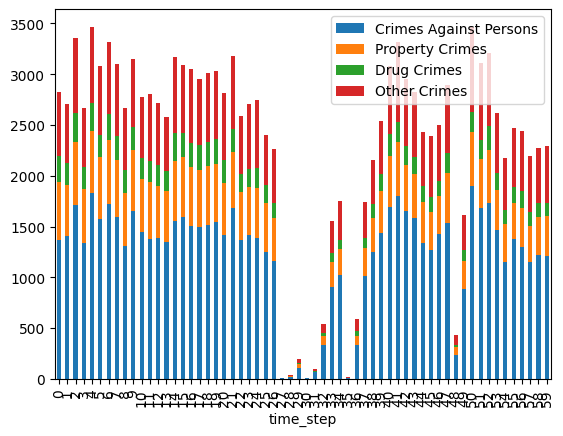

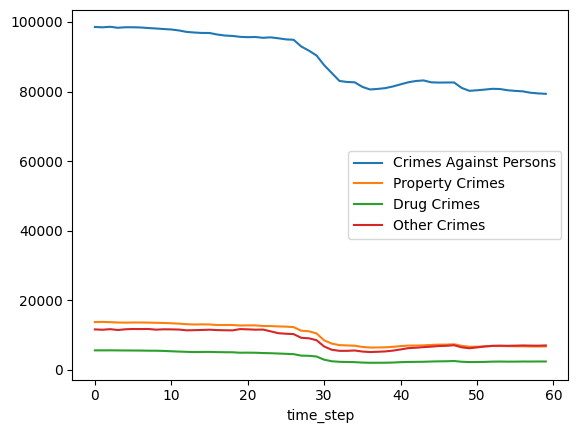

In [79]:
# add time step column, graph data

total_pop["time_step"] = total_pop.index
# total_pop_chart = total_pop.drop(["Month", "Year"], axis=1).plot.bar(x='time_step', stacked=True)

admissions["time_step"] = total_pop.index
admissions_chart = admissions.drop(["Month", "Year"], axis=1).plot.bar(x='time_step', stacked=True)

total_pop.drop(["Month", "Year"], axis=1).plot(x='time_step')

In [12]:
# in the future: look at ARIMA line of best fit to make sure it makes sense

Next step: Transitions Data

In [13]:
# how do you use total population and admissions data to get transitions data?

# total number of people
# number of people coming into prison
# goal: how long they stay in prison

# admissions * LOS = population

[]

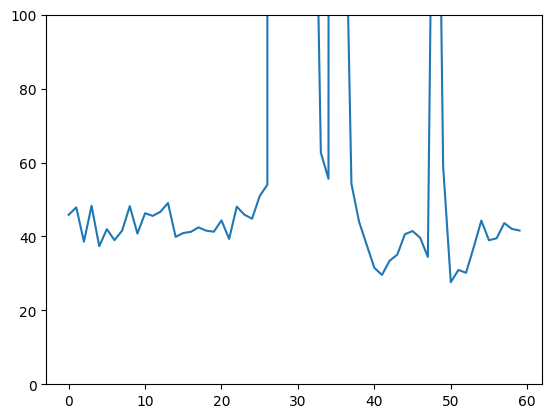

In [14]:
# plot average population / average admissions

los = (total_pop.iloc[:, 0:4].sum(axis=1) / admissions.iloc[:, 0:4].sum(axis=1)).plot(ylim = [0,100])
los.plot()

In [15]:
# find average LOS of each crime type by dividing population / admission 
total_pop
avg_LOS = total_pop.iloc[:, 0:4].sum() / admissions.iloc[:, 0:4].sum()

avg_LOS

Crimes Against Persons    72.155303
Property Crimes           24.255618
Drug Crimes               22.410930
Other Crimes              16.609226
dtype: float64

In [16]:
# LOS(t-1) = total_pop(t-1) / admissions - delta(total_pop(t))
# delta(total_pop(t)) = total_pop(t) - total_pop(t - 1)

silly_goose = total_pop.iloc[:, 0:4].sum(axis=1)
silly_goose_t = silly_goose[1:]
silly_goose_previous = silly_goose[:-1]

admissions_total = admissions.iloc[1:, 0:4].sum(axis=1)

los = silly_goose_previous.reset_index(drop=True) / (admissions_total.reset_index(drop=True)
                                                     + silly_goose_previous.reset_index(drop=True)
                                                     - silly_goose_t.reset_index(drop=True))

los_avg = los.sum() / len(los)

In [17]:
# this cell gets an avg LOS for each crime type using the formula
# LOS(t-1) = total_pop(t-1) / admissions - delta(total_pop(t))
# delta(total_pop(t)) = total_pop(t) - total_pop(t - 1)

# silly_goose = total_pop.iloc[:, 0:4]

# silly_goose_t = silly_goose[1:]
# silly_goose_previous = silly_goose[:-1]
# admissions_total = admissions.iloc[1:, 0:4]
# los = silly_goose_previous.reset_index(drop=True) / (admissions_total.reset_index(drop=True)
#                                                      + silly_goose_previous.reset_index(drop=True)
#                                                      - silly_goose_t.reset_index(drop=True))

In [20]:
los = (los,)

bootstrap_ci = bootstrap(los, np.mean, confidence_level=0.95,
                         random_state=1, method='percentile')
plt.hist(bootstrap_ci.bootstrap_distribution, bins=30)
std_err = bootstrap_ci.standard_error
lognorm.rvs(s=1, scale=np.math.exp(1), size=1000)

BootstrapResult(confidence_interval=ConfidenceInterval(low=38.43236046516201, high=43.021298025035804), bootstrap_distribution=array([38.95697124, 40.97817254, 41.18318209, ..., 38.52347194,
       40.23614818, 40.88134466]), standard_error=1.1693378557482725)

In [23]:
# this cell gets an avg LOS for each crime type using the formula
# LOS(t-1) = total_pop(t-1) / admissions - delta(total_pop(t))
# delta(total_pop(t)) = total_pop(t) - total_pop(t - 1)

silly_goose = total_pop.iloc[:, 0:4]

silly_goose_t = silly_goose[1:]
silly_goose_previous = silly_goose[:-1]
admissions_total = admissions.iloc[1:, 0:4]
los = silly_goose_previous.reset_index(drop=True) / (admissions_total.reset_index(drop=True)
                                                     + silly_goose_previous.reset_index(drop=True)
                                                     - silly_goose_t.reset_index(drop=True))

In [25]:
crimes_against_persons_los = (los["Crimes Against Persons"],)
bootstrap_ci_cap = bootstrap(crimes_against_persons_los, np.mean, confidence_level=0.95,
                          random_state=1, method='percentile')
cap_transitions = bootstrap_ci_cap.bootstrap_distribution         

property_crimes_los = (los["Property Crimes"],)
bootstrap_ci_prop = bootstrap(property_crimes_los, np.mean, confidence_level=0.95,
                          random_state=1, method='percentile')
prop_transitions = bootstrap_ci_prop.bootstrap_distribution 

drug_crimes_los = (los["Drug Crimes"],)
bootstrap_ci_drug = bootstrap(drug_crimes_los, np.mean, confidence_level=0.95,
                          random_state=1, method='percentile')
drug_transitions = bootstrap_ci_drug.bootstrap_distribution 

other_crimes_los = (los["Other Crimes"],)
bootstrap_ci_other = bootstrap(other_crimes_los, np.mean, confidence_level=0.95,
                          random_state=1, method='percentile')
other_transitions = bootstrap_ci_other.bootstrap_distribution 

In [96]:
# visualize the transitions data we've created

# plt.hist(cap_transitions, bins=30)
# plt.hist(prop_transitions, bins=30, alpha = 0.5)
# plt.hist(drug_transitions, bins=30, alpha = 0.5)
# plt.hist(other_transitions, bins=30, alpha = 0.5)

In [27]:
# let's create the transitions table!

transitions = pd.DataFrame({
    'compartment': ["prison"] * (9999 * 4) + ["release"] * 4,
    'outflow_to': ["release"] * (9999 * 4) + ["release"] * 4,
    'crime_type': (["Crimes Against Persons"] * 9999) + (["Property Crimes"] * 9999) + (["Drug Crimes"] * 9999) + (["Other Crimes"] * 9999) + ["Crimes Against Persons", "Property Crimes", "Drug Crimes", "Other Crimes"],
    'compartment_duration': list(cap_transitions) + list(prop_transitions) + list(drug_transitions) + list(other_transitions) + [1.0] * 4,
    'total_population': [1.0] * (10000 * 4)
})

transitions

,compartment,outflow_to,crime_type,compartment_duration,total_population
0,prison,release,Crimes Against Persons,58.537117,1.0
1,prison,release,Crimes Against Persons,60.988930,1.0
2,prison,release,Crimes Against Persons,60.309418,1.0
3,prison,release,Crimes Against Persons,59.927144,1.0
4,prison,release,Crimes Against Persons,57.197566,1.0
...,...,...,...,...,...
39995,prison,release,Other Crimes,16.500964,1.0
39996,release,release,Crimes Against Persons,1.000000,1.0
39997,release,release,Property Crimes,1.000000,1.0
39998,release,release,Drug Crimes,1.000000,1.0


In [28]:
# old simplified transitions table

# transitions = pd.DataFrame({
#     'compartment': ["prison"] * 4 + ["release"] * 4,
#     'outflow_to': ["release"] * 8,
#     'crime_type': ["Crimes Against Persons", "Property Crimes", "Drug Crimes", "Other Crimes"] * 2,
#     'compartment_duration': list(los_avg) + [1.0] * 4,
#     'total_population': [1.0] * 8
# })

# transitions = transitions.reset_index().rename({'index': 'crime_type'}, axis=1)

In [83]:
# let's create the outflows table! multiple ways to do it

# way 1: wrong!
# outflows = pd.DataFrame(
#     {"compartment": ["pretrial"] * 240,
#     "outflow_to": ["prison"] * 240,
#     "crime_type": ["Crimes Against Persons", "Property Crimes", "Drug Crimes", "Other Crimes"] * 60,
#     "time_step": list(range(60)) * 4,}
# )

# pop = []
# for _,row in outflows.iterrows():
#     crime = row["crime_type"]
#     time = row["time_step"]
#     pop.append((admissions[admissions.time_step == time][crime]).iloc[0])

# outflows["total_population"] = pop

# way 2:
outflows = pd.DataFrame(
    {"compartment": ["pretrial"] * 240,
     "outflow_to": ["prison"] * 240,
     "crime_type": (["Crimes Against Persons"] * 60) + (["Property Crimes"] * 60) + (["Drug Crimes"] * 60) + (["Other Crimes"] * 60),
     "time_step": list(range(60)) * 4,
     "total_population": list(admissions["Crimes Against Persons"]) + list(admissions["Property Crimes"]) + list(admissions["Drug Crimes"]) + list(admissions["Other Crimes"]),
    }
)

# way 3:
# admissions.melt(
#     value_vars=["Crimes Against Persons", "Property Crimes", "Drug Crimes", "Other Crimes"],
#     id_vars=['time_step']
# )


In [84]:
outflows_data = outflows
outflows_data.total_population = outflows_data.total_population.astype(float)


In [86]:
# create total population table

total_population = pd.DataFrame({
    'compartment': ['prison'] * 240,
    'time_step': list(range(60)) * 4,
    'crime_type': (["Crimes Against Persons"] * 60) + (["Property Crimes"] * 60) + (["Drug Crimes"] * 60) + (["Other Crimes"] * 60),
    'total_population': list(total_pop['Crimes Against Persons']) + list(total_pop['Property Crimes']) + list(total_pop['Drug Crimes']) + list(total_pop['Other Crimes'])
})


In [87]:
total_population_data = total_population
transitions_data = transitions

total_population_data.total_population = total_population_data.total_population.astype(float)

In [92]:
# STEP 1: pick a `simulation_tag` for your simulation. "paco_parole_test" would be a reasonable example...
simulation_tag = "ca_preprocessing"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/CA/ca_preprocessing_model_inputs.yml',
)

In [93]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/CA/ca_preprocessing_model_inputs.yml'
)

/Users/ayeshakhawaja/.local/share/virtualenvs/stanford-decarceration-collective-2t2SjLv5/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(
/Users/ayeshakhawaja/.local/share/virtualenvs/stanford-decarceration-collective-2t2SjLv5/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(
/Users/ayeshakhawaja/.local/share/virtualenvs/stanford-decarceration-collective-2t2SjLv5/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation_factory.py:160: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for simulation_group_name, _ in transitions_data.groupby(disaggregation_axes):


initialization time:  3.0251593589782715


/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/aye

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

simulation_time:  12.836386919021606


/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../super_simulation/simulator.py:269: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simulation_results = simulation_results.groupby(


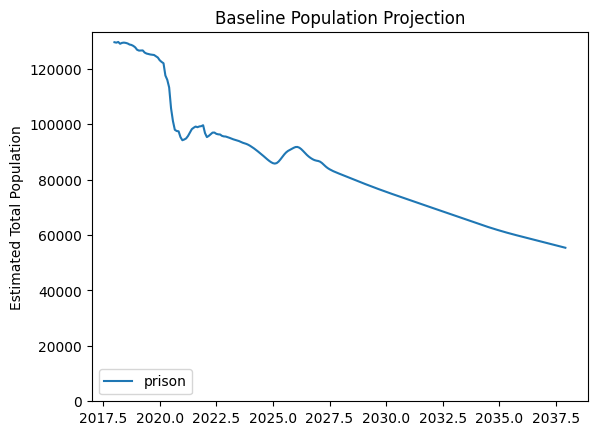

In [94]:
# This can take several minutes to run. You'll see six checkpoints printed out along the way before it finishes.
display_compartments = ['prison']
spark_sim.simulate_baseline(display_compartments)

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:312: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arima_output_df = arima_output_df.append(output_df_sub)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:312: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arima_output_df = arima_output_df.append(output_df_sub)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:312: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

[<Axes: title={'center': 'simulation_group: Crimes Against Persons\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <Axes: title={'center': 'simulation_group: Drug Crimes\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <Axes: title={'center': 'simulation_group: Other Crimes\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <Axes: title={'center': 'simulation_group: Property Crimes\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

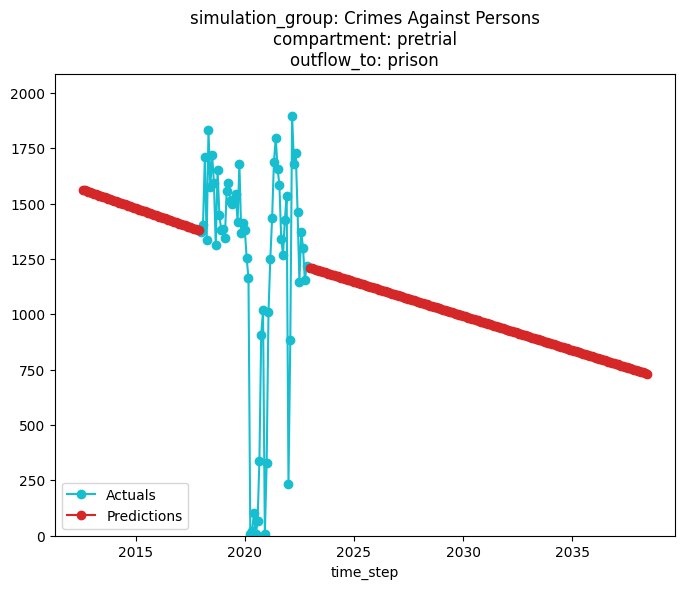

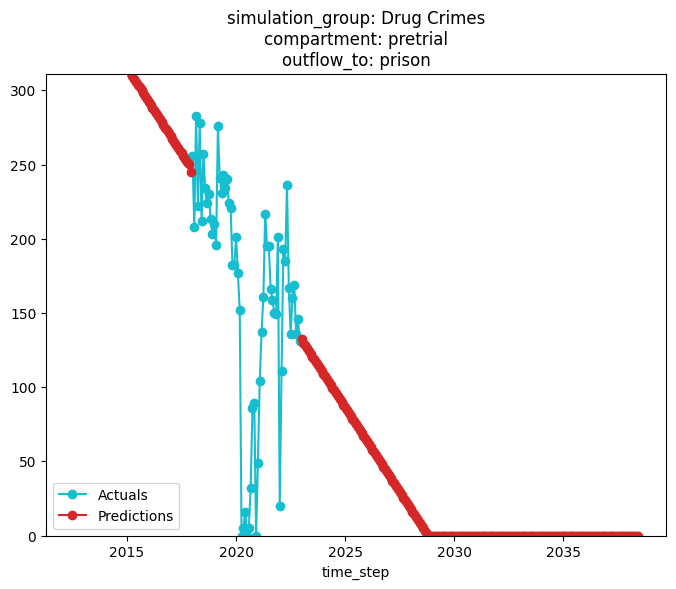

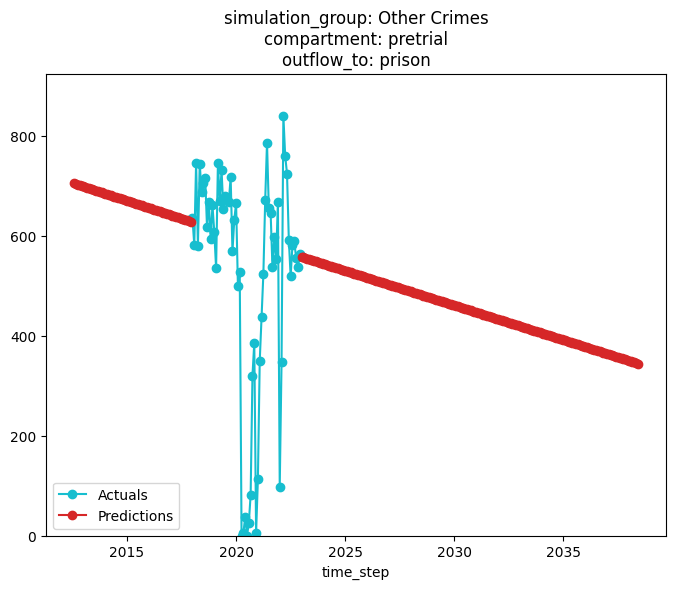

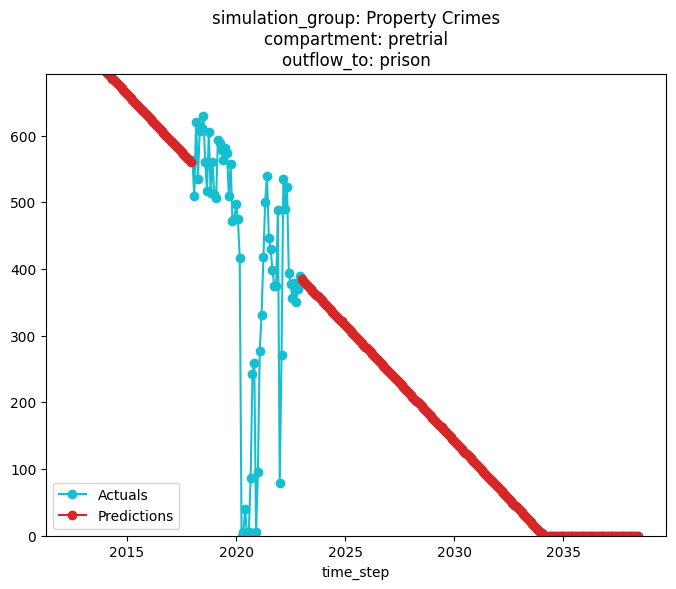

In [95]:
spark_sim.get_arima_output_plots('baseline_projections', by_simulation_group= True)